In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm.auto import tqdm
import numpy as np
from copy import deepcopy

import rospy
import actionlib

from tams_pr2_guzheng.paths import RuckigPath
from tams_pr2_guzheng.onset_to_path import OnsetToPath
from tams_pr2_guzheng.utils import *
from tams_pr2_guzheng.msg import RunEpisodeAction

%matplotlib inline

In [2]:
rospy.init_node('jupyter', anonymous=True)

In [3]:
run_episode = actionlib.SimpleActionClient('run_episode', RunEpisodeAction)
run_episode.wait_for_server()

True

In [4]:
o2p = OnsetToPath(storage='/tmp/plucks.json')

1687381716.227272: /jupyter_511654_1687381715669.rosout: OnsetToPath stores 60 plucks
F♯4: 46 plucks
A4: 5 plucks
None: 9 plucks

fis4: 60 plucks



In [5]:
note= 'F♯4'
targets = np.repeat(np.linspace(*o2p.get_note_min_max('F♯4'), 10), 7)
targets

array([ 8.94813633,  8.94813633,  8.94813633,  8.94813633,  8.94813633,
        8.94813633,  8.94813633, 12.01901033, 12.01901033, 12.01901033,
       12.01901033, 12.01901033, 12.01901033, 12.01901033, 15.08988433,
       15.08988433, 15.08988433, 15.08988433, 15.08988433, 15.08988433,
       15.08988433, 18.16075834, 18.16075834, 18.16075834, 18.16075834,
       18.16075834, 18.16075834, 18.16075834, 21.23163234, 21.23163234,
       21.23163234, 21.23163234, 21.23163234, 21.23163234, 21.23163234,
       24.30250634, 24.30250634, 24.30250634, 24.30250634, 24.30250634,
       24.30250634, 24.30250634, 27.37338034, 27.37338034, 27.37338034,
       27.37338034, 27.37338034, 27.37338034, 27.37338034, 30.44425435,
       30.44425435, 30.44425435, 30.44425435, 30.44425435, 30.44425435,
       30.44425435, 33.51512835, 33.51512835, 33.51512835, 33.51512835,
       33.51512835, 33.51512835, 33.51512835, 36.58600235, 36.58600235,
       36.58600235, 36.58600235, 36.58600235, 36.58600235, 36.58

In [29]:
o2p.pluck_table['string_position'].describe()

count    60.000000
mean      0.173282
std       0.122500
min       0.000472
25%       0.071125
50%       0.174080
75%       0.275830
max       0.348061
Name: string_position, dtype: float64

In [31]:
characterize_run= "loudness_performance-15perdirransac-30perdirloudness-dir-1.0-position0.17"
df = pd.DataFrame(columns= ['target_loudness', 'loudness', 'only_expected'])
results = []
for t in tqdm(targets):
    p, _finger = o2p.get_path(note, 'ff', -1.0, t, 0.17)
    r = run_params(run_episode, p, finger='ff')
    expected_onsets = sorted([o for o in r.onsets if o.note == note], key= lambda o: o.loudness, reverse= True)
    unexpected_onsets = sorted([o for o in r.onsets if o.note != note], key= lambda o: o.loudness, reverse= True)


    if len(unexpected_onsets) > 0:
        row = {'target_loudness': t, 'loudness': unexpected_onsets[0].loudness, 'only_expected': False}
    elif len(expected_onsets) == 0:
        row = {'target_loudness': t, 'loudness': 0.0, 'only_expected': True}
    else:
        row = {'target_loudness': t, 'loudness': expected_onsets[0].loudness, 'only_expected': True}

    row_df = pd.DataFrame(row, columns= row.keys(), index= [0])
    df = pd.concat((df, row_df), axis= 0, ignore_index=True)

  0%|          | 0/70 [00:00<?, ?it/s]

1687383775.162467: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383781.329490: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383794.002250: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383800.199445: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383850.087445: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383899.599424: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383918.113208: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
1687383980.534526: /jupyter_511654_1687381715669.rosout: Got a transition callback on a goal handle that we're not tracking
16873839

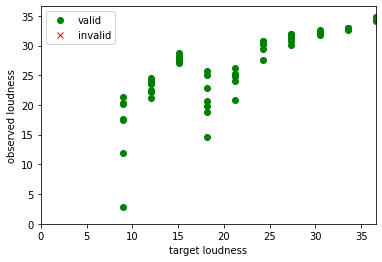

In [34]:
plt.figure()
df[df['only_expected']].plot(x= 'target_loudness', y= 'loudness', style= 'go', ax= plt.gca());
df[np.logical_not(df['only_expected'])].plot(x= 'target_loudness', y= 'loudness', style= 'rx', ax= plt.gca());
plt.xlabel('target loudness')
plt.ylabel('observed loudness')

lim = (0.0, targets.max())
plt.xlim(lim)
plt.ylim(lim)
plt.legend(['valid', 'invalid'], loc= 'upper left')

plt.savefig(f'/tmp/{characterize_run}.png', dpi= 300)
df.to_json(f'/tmp/{characterize_run}.json')

In [33]:
characterize_run= "loudness_performance-15perdirransac-30perdirloudness-dir1.0-variableposition"
df = pd.read_json(f"/tmp/{characterize_run}.json")